# RNA Structure Analysis & ESM Implementation

This notebook explores RNA sequence data and implements ESM for structure prediction.

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import re
from collections import Counter

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Data Loading and Initial Exploration

In [5]:
# Load data
train_df = pd.read_csv('../../data/raw/train.csv')
test_df = pd.read_csv('../../data/raw/test.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Display first few rows
train_df.head()

Training data shape: (2400, 689)
Test data shape: (3634, 7)


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error.0,...,deg_50C.58,deg_50C.59,deg_50C.60,deg_50C.61,deg_50C.62,deg_50C.63,deg_50C.64,deg_50C.65,deg_50C.66,deg_50C.67
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,0.1359,...,0.3912,0.3724,0.4432,0.2169,0.1959,0.2391,0.4234,0.3287,0.5301,0.8472
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,2.8272,...,3.6521,4.0795,2.3008,0.0000,2.8405,2.6446,0.0000,-3.1956,0.0000,0.0000
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,0.0931,...,0.2674,0.4052,0.7162,0.6113,0.6801,0.9186,0.4832,0.7789,0.3348,0.5827
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,3.5229,...,6.9722,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,16.1462
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,1.6650,...,0.0000,0.5900,0.0000,0.0000,1.1447,0.4560,0.0000,0.0000,1.0802,1.5546


## 2. Sequence Analysis

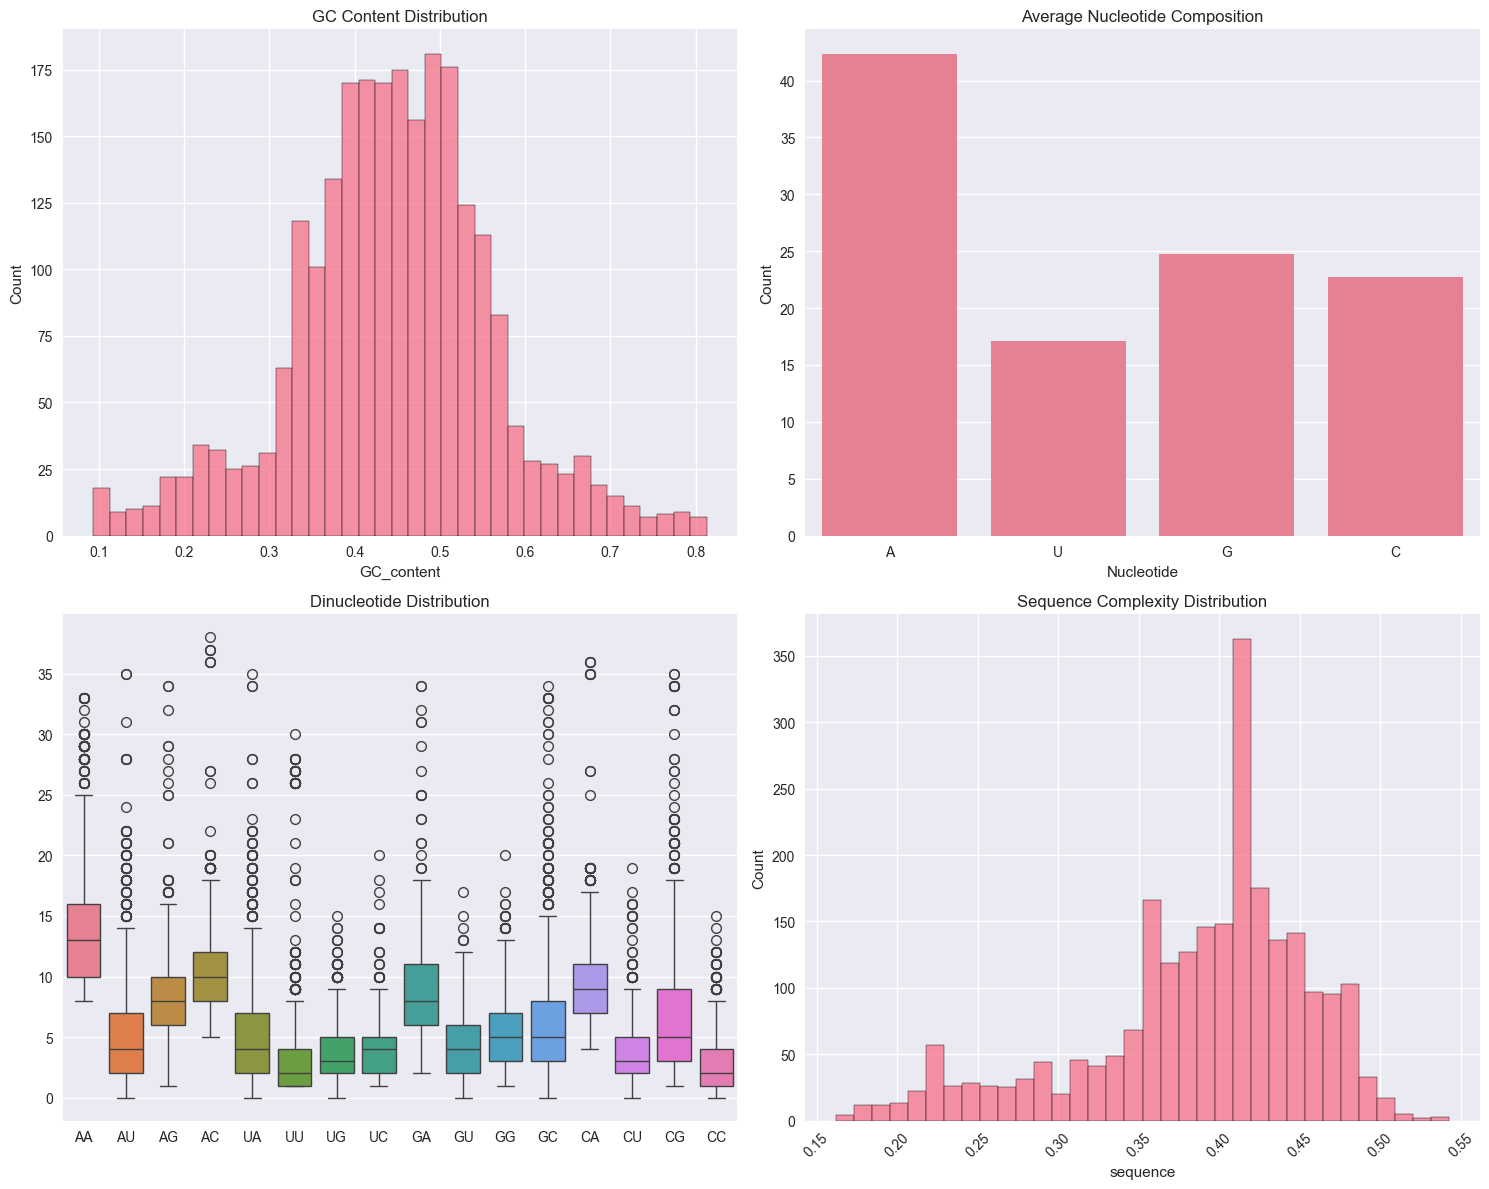

In [6]:
def analyze_sequence(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze sequence characteristics"""
    # Calculate basic sequence properties
    seq_properties = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'GC_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x)),
        'AU_content': df['sequence'].apply(lambda x: (x.count('A') + x.count('U')) / len(x)),
        'A_count': df['sequence'].str.count('A'),
        'U_count': df['sequence'].str.count('U'),
        'G_count': df['sequence'].str.count('G'),
        'C_count': df['sequence'].str.count('C')
    })
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    sns.histplot(data=seq_properties, x='GC_content', ax=axes[0,0])
    axes[0,0].set_title('GC Content Distribution')
    
    nucleotides = pd.DataFrame({
        'Nucleotide': ['A', 'U', 'G', 'C'],
        'Count': [seq_properties['A_count'].mean(),
                 seq_properties['U_count'].mean(),
                 seq_properties['G_count'].mean(),
                 seq_properties['C_count'].mean()]
    })
    sns.barplot(data=nucleotides, x='Nucleotide', y='Count', ax=axes[0,1])
    axes[0,1].set_title('Average Nucleotide Composition')
    
    # Sequence motif analysis
    dinucleotides = ['AA', 'AU', 'AG', 'AC', 'UA', 'UU', 'UG', 'UC',
                     'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG', 'CC']
    motif_counts = pd.DataFrame()
    for motif in dinucleotides:
        motif_counts[motif] = df['sequence'].str.count(motif)
    
    sns.boxplot(data=motif_counts, ax=axes[1,0])
    axes[1,0].set_title('Dinucleotide Distribution')
    plt.xticks(rotation=45)
    
    # Sequence complexity (unique k-mers)
    def sequence_complexity(seq, k=3):
        kmers = [seq[i:i+k] for i in range(len(seq)-k+1)]
        return len(set(kmers)) / len(kmers)
    
    complexity = df['sequence'].apply(sequence_complexity)
    sns.histplot(data=complexity, ax=axes[1,1])
    axes[1,1].set_title('Sequence Complexity Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return seq_properties

seq_features = analyze_sequence(train_df)

## 3. Structure Analysis

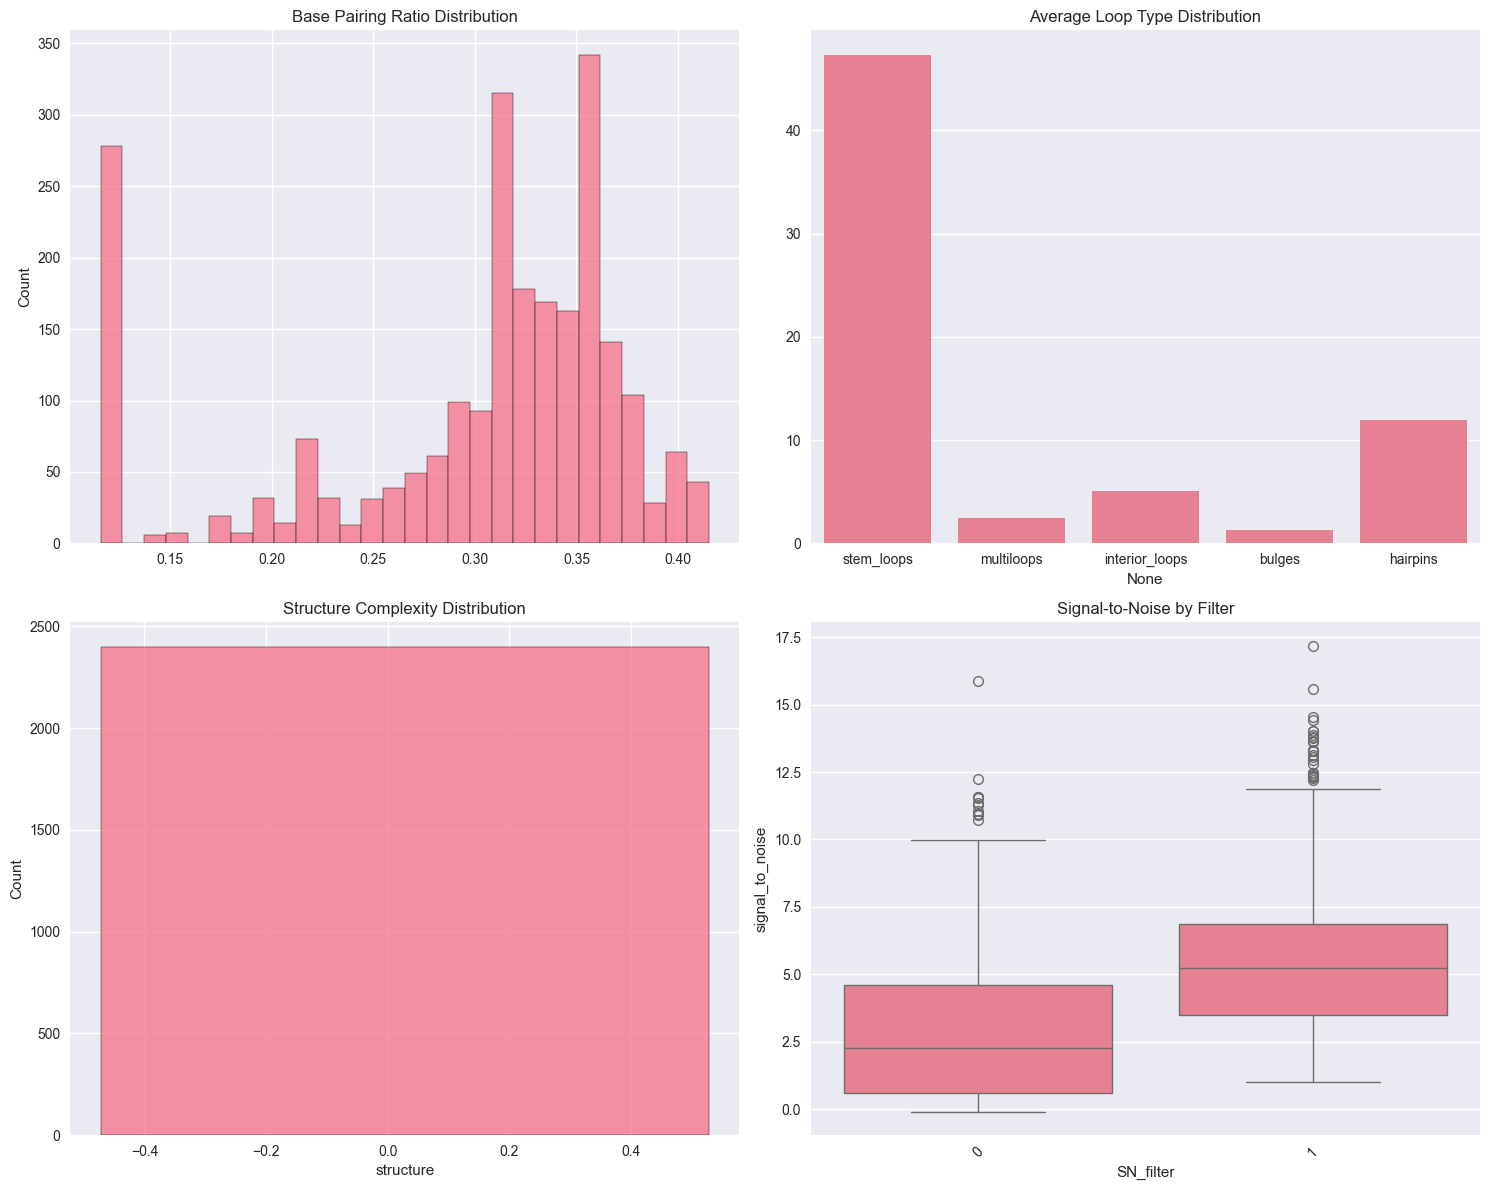

In [7]:
def analyze_structure(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze RNA secondary structure"""
    # Calculate structure properties
    struct_properties = pd.DataFrame({
        'paired_bases': df['structure'].str.count('\(') + df['structure'].str.count('\)'),
        'unpaired_bases': df['structure'].str.count('.'),
        'stem_loops': df['predicted_loop_type'].str.count('S'),
        'multiloops': df['predicted_loop_type'].str.count('M'),
        'interior_loops': df['predicted_loop_type'].str.count('I'),
        'bulges': df['predicted_loop_type'].str.count('B'),
        'hairpins': df['predicted_loop_type'].str.count('H')
    })
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Pairing ratio
    pairing_ratio = struct_properties['paired_bases'] / (struct_properties['paired_bases'] + struct_properties['unpaired_bases'])
    sns.histplot(data=pairing_ratio, ax=axes[0,0])
    axes[0,0].set_title('Base Pairing Ratio Distribution')
    
    # Loop type distribution
    loop_counts = struct_properties[['stem_loops', 'multiloops', 'interior_loops', 'bulges', 'hairpins']].mean()
    sns.barplot(x=loop_counts.index, y=loop_counts.values, ax=axes[0,1])
    axes[0,1].set_title('Average Loop Type Distribution')
    plt.xticks(rotation=45)
    
    # Structure complexity
    def structure_complexity(struct):
        return len(set(struct)) / len(struct)
    
    complexity = df['structure'].apply(structure_complexity)
    sns.histplot(data=complexity, ax=axes[1,0])
    axes[1,0].set_title('Structure Complexity Distribution')
    
    # Signal-to-noise analysis
    sns.boxplot(data=df, x='SN_filter', y='signal_to_noise', ax=axes[1,1])
    axes[1,1].set_title('Signal-to-Noise by Filter')
    
    plt.tight_layout()
    plt.show()
    
    return struct_properties

struct_features = analyze_structure(train_df)

## 4. Error Analysis

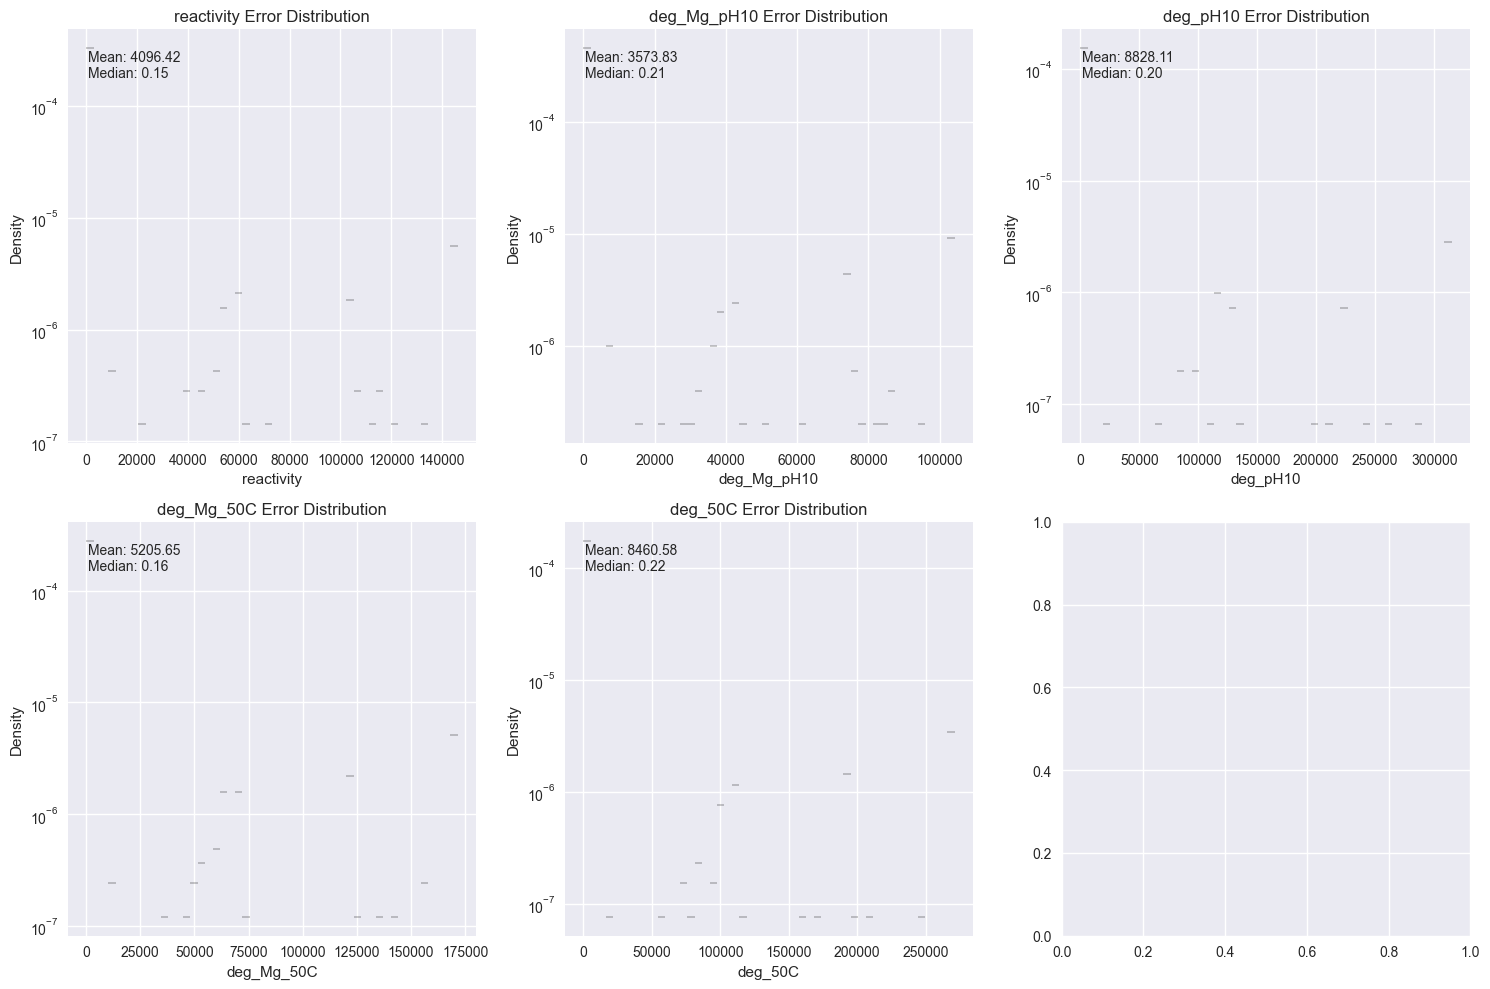

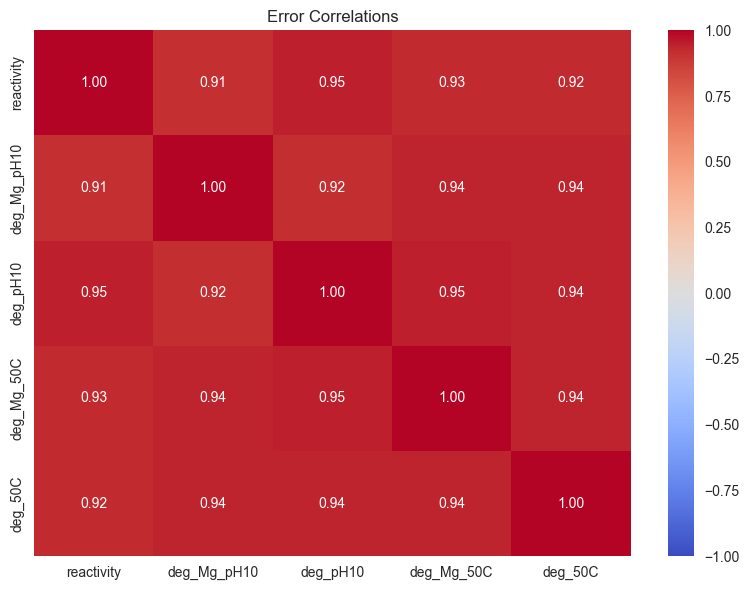


Error Summary Statistics:

reactivity:
Mean: 4096.4229
Median: 0.1536
Std Dev: 21743.3711
% of outliers: 2.50%

deg_Mg_pH10:
Mean: 3573.8341
Median: 0.2114
Std Dev: 17148.4591
% of outliers: 3.25%

deg_pH10:
Mean: 8828.1138
Median: 0.2027
Std Dev: 47327.8520
% of outliers: 2.46%

deg_Mg_50C:
Mean: 5205.6501
Median: 0.1592
Std Dev: 26530.6498
% of outliers: 2.71%

deg_50C:
Mean: 8460.5768
Median: 0.2178
Std Dev: 42739.3829
% of outliers: 2.88%


In [8]:
def analyze_errors_optimized(df: pd.DataFrame):
    """Analyze error distributions and patterns with optimized performance"""
    # Pre-define error groups with explicit column lists for better performance
    error_groups = {
        'reactivity': df[[col for col in df.columns if col.startswith('reactivity_error')]].iloc[:, :10],  # Take first 10 columns
        'deg_Mg_pH10': df[[col for col in df.columns if col.startswith('deg_error_Mg_pH10')]].iloc[:, :10],
        'deg_pH10': df[[col for col in df.columns if col.startswith('deg_error_pH10')]].iloc[:, :10],
        'deg_Mg_50C': df[[col for col in df.columns if col.startswith('deg_error_Mg_50C')]].iloc[:, :10],
        'deg_50C': df[[col for col in df.columns if col.startswith('deg_error_50C')]].iloc[:, :10]
    }
    
    # Calculate means once
    error_means = pd.DataFrame({
        name: group.mean(axis=1) 
        for name, group in error_groups.items()
    })
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Plot distributions with optimized settings
    for idx, (name, errors) in enumerate(error_means.items()):
        if idx < len(axes):  # Ensure we don't exceed available axes
            sns.histplot(
                data=errors,
                ax=axes[idx],
                bins=50,  # Reduce number of bins
                stat='density',  # Use density instead of count
                log_scale=(False, True)  # Log scale for y-axis to handle outliers
            )
            axes[idx].set_title(f'{name} Error Distribution')
            
            # Add summary statistics
            mean_val = errors.mean()
            median_val = errors.median()
            axes[idx].text(
                0.05, 0.95,
                f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}',
                transform=axes[idx].transAxes,
                verticalalignment='top'
            )
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot correlations
    plt.figure(figsize=(8, 6))
    corr_matrix = error_means.corr()
    
    # Plot correlation heatmap with simplified settings
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1
    )
    plt.title('Error Correlations')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nError Summary Statistics:")
    print("========================")
    for name, errors in error_means.items():
        print(f"\n{name}:")
        print(f"Mean: {errors.mean():.4f}")
        print(f"Median: {errors.median():.4f}")
        print(f"Std Dev: {errors.std():.4f}")
        print(f"% of outliers: {(np.abs(errors - errors.mean()) > (3 * errors.std())).mean() * 100:.2f}%")

# Usage
analyze_errors_optimized(train_df)

## 5. Prepare Data for ESM

In [9]:
def prepare_esm_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """Prepare sequences and targets for ESM model"""
    # Convert sequences to ESM format
    sequences = df['sequence'].values
    
    # Extract target variables
    targets = df[[col for col in df.columns if any(x in col for x in 
                 ['reactivity.', 'deg_Mg_pH10.', 'deg_pH10.', 'deg_Mg_50C.', 'deg_50C.'])]].values
    
    return sequences, targets

# Prepare data
X_train, y_train = prepare_esm_data(train_df)
print("Training data shape:", X_train.shape)
print("Target data shape:", y_train.shape)

Training data shape: (2400,)
Target data shape: (2400, 340)


Processed Data Summary:
Number of sequences: 2097
Feature matrix shape: (2097, 14)

Target shapes:
reactivity: (2097, 68)
deg_Mg_pH10: (2097, 68)
deg_pH10: (2097, 68)
deg_Mg_50C: (2097, 68)
deg_50C: (2097, 68)

Feature Statistics:
                0            1       2       3            4            5   \
count  2097.000000  2097.000000  2097.0  2097.0  2097.000000  2097.000000   
mean     -0.025054     0.025054     0.0     0.0    -0.269433     0.269433   
std       0.772641     0.772641     0.0     0.0     0.891063     0.891063   
min      -2.461538    -2.307692     0.0     0.0    -2.375000    -1.375000   
25%      -0.538462    -0.461538     0.0     0.0    -0.625000    -0.375000   
50%       0.000000     0.000000     0.0     0.0     0.000000     0.000000   
75%       0.461538     0.538462     0.0     0.0     0.375000     0.625000   
max       2.307692     2.461538     0.0     0.0     1.375000     2.375000   

           6            7            8            9            10  \
count 

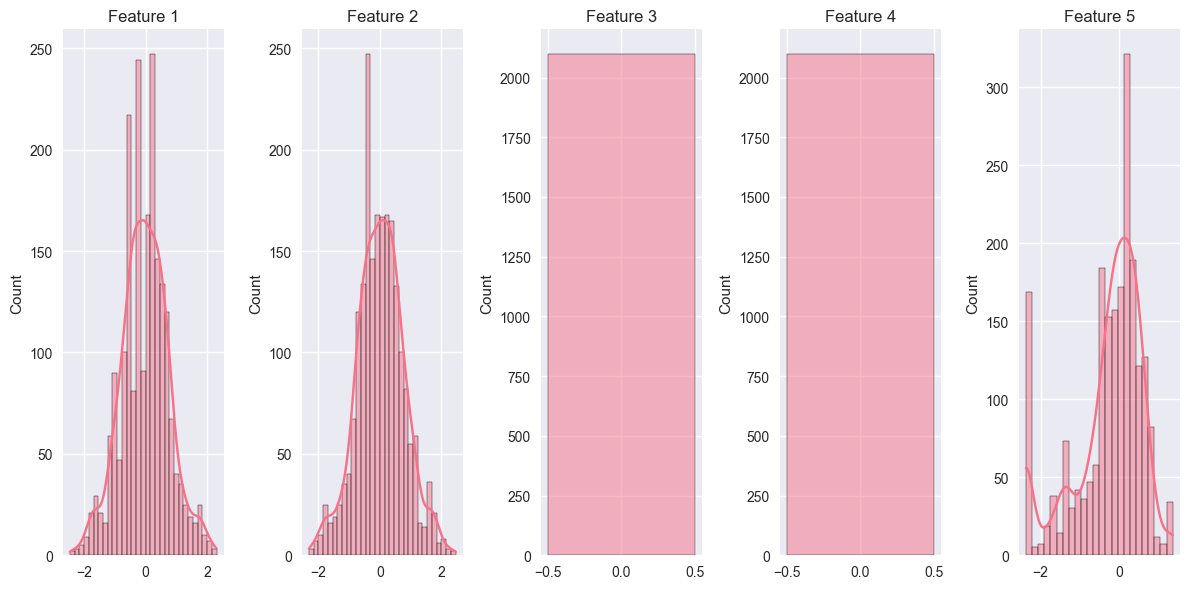

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from typing import Tuple, Dict, List
from collections import defaultdict

class ESMPreprocessor:
    def __init__(self, sn_threshold: float = 1.0):
        self.sn_threshold = sn_threshold
        self.scaler = RobustScaler()
        
    def filter_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter data based on signal-to-noise ratio"""
        return df[df['signal_to_noise'] >= self.sn_threshold].copy()
    
    def extract_sequence_features(self, sequence: str) -> Dict[str, float]:
        """Extract numerical features from sequence"""
        return {
            'gc_content': (sequence.count('G') + sequence.count('C')) / len(sequence),
            'au_content': (sequence.count('A') + sequence.count('U')) / len(sequence),
            'sequence_length': len(sequence),
            'complexity': len(set(sequence)) / len(sequence)
        }
    
    def extract_structure_features(self, structure: str) -> Dict[str, float]:
        """Extract numerical features from structure"""
        paired = structure.count('(') + structure.count(')')
        unpaired = structure.count('.')
        total = len(structure)
        
        return {
            'paired_ratio': paired / (2 * total),
            'unpaired_ratio': unpaired / total,
            'structure_complexity': len(set(structure)) / total
        }
    
    def extract_loop_features(self, loop_type: str) -> Dict[str, float]:
        """Extract numerical features from loop type annotation"""
        total = len(loop_type)
        return {
            'stem_ratio': loop_type.count('S') / total,
            'multiloop_ratio': loop_type.count('M') / total,
            'interior_ratio': loop_type.count('I') / total,
            'bulge_ratio': loop_type.count('B') / total,
            'hairpin_ratio': loop_type.count('H') / total,
            'external_ratio': loop_type.count('E') / total
        }

    def prepare_esm_input(self, df: pd.DataFrame) -> Tuple[List[str], np.ndarray]:
        """Prepare sequences and features for ESM model"""
        # Filter data
        df_filtered = self.filter_data(df)
        
        sequences = []
        feature_dicts = []
        
        # Extract features for each sequence
        for _, row in df_filtered.iterrows():
            seq_features = self.extract_sequence_features(row['sequence'])
            struct_features = self.extract_structure_features(row['structure'])
            loop_features = self.extract_loop_features(row['predicted_loop_type'])
            
            # Combine all features
            combined_features = {
                **seq_features,
                **struct_features,
                **loop_features,
                'signal_to_noise': row['signal_to_noise']
            }
            
            sequences.append(row['sequence'])
            feature_dicts.append(combined_features)
        
        # Convert feature dictionaries to DataFrame
        feature_df = pd.DataFrame(feature_dicts)
        
        # Scale features
        scaled_features = self.scaler.fit_transform(feature_df)
        
        return sequences, scaled_features
    
    def prepare_targets(self, df: pd.DataFrame) -> Dict[str, np.ndarray]:
        """Prepare target variables with outlier handling"""
        df_filtered = self.filter_data(df)
        
        # Initialize storage for processed targets
        targets = {}
        
        # Process each target type
        target_prefixes = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
        
        for prefix in target_prefixes:
            # Get all columns for this target
            target_cols = [col for col in df_filtered.columns 
                         if col.startswith(prefix + '.') and col.split('.')[1].isdigit()]
            
            if target_cols:
                # Extract and convert to float array
                target_values = df_filtered[target_cols].values.astype(float)
                
                # Apply robust scaling
                scaled_values = self.scaler.fit_transform(target_values)
                targets[prefix] = scaled_values
        
        return targets

def analyze_processed_data(sequences: List[str], features: np.ndarray, targets: Dict[str, np.ndarray]):
    """Analyze the processed data"""
    print("Processed Data Summary:")
    print(f"Number of sequences: {len(sequences)}")
    print(f"Feature matrix shape: {features.shape}")
    print("\nTarget shapes:")
    for name, target in targets.items():
        print(f"{name}: {target.shape}")
    
    # Print feature statistics
    feature_df = pd.DataFrame(features)
    print("\nFeature Statistics:")
    print(feature_df.describe())
    
    # Plot feature distributions
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 6))
    for i in range(min(5, features.shape[1])):  # Plot first 5 features
        plt.subplot(1, 5, i+1)
        sns.histplot(features[:, i], kde=True)
        plt.title(f'Feature {i+1}')
    plt.tight_layout()
    plt.show()

# Usage example
preprocessor = ESMPreprocessor(sn_threshold=1.0)
sequences, features = preprocessor.prepare_esm_input(train_df)
targets = preprocessor.prepare_targets(train_df)

# Analyze the processed data
analyze_processed_data(sequences, features, targets)


Loading and preprocessing data...

Dataset Overview:
Total sequences: 2097
Feature matrix shape: (2097, 15)

Sample sequence:
GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUG...


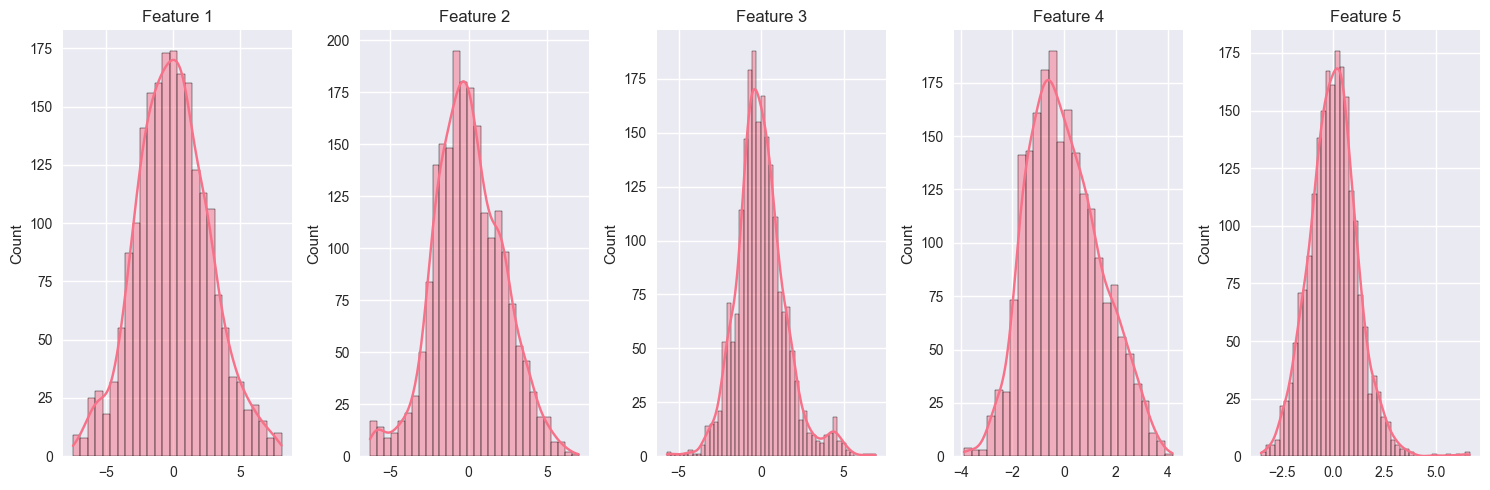

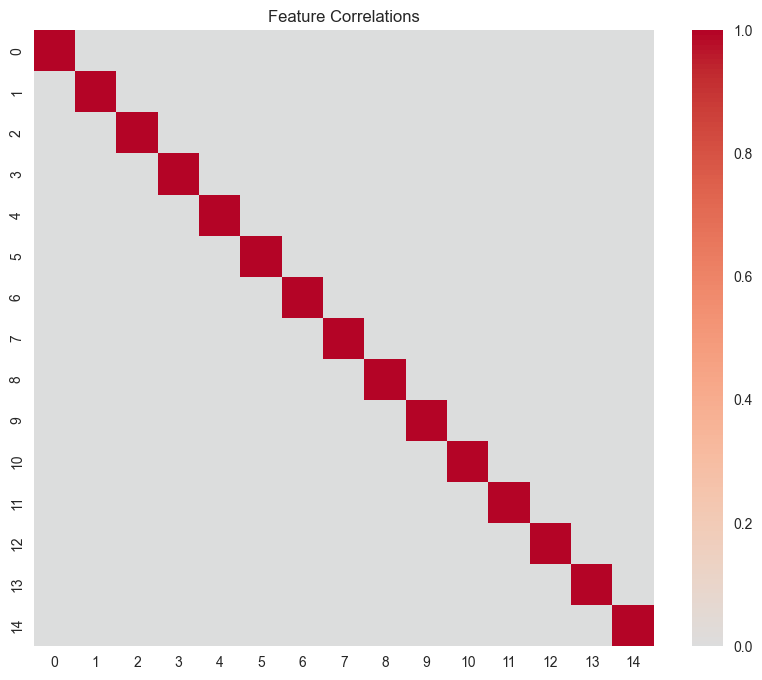


Target Statistics:

reactivity:
Shape: torch.Size([2097, 68])
Mean: 0.000
Std: 1.000
Min: -20.366
Max: 5.792

deg_Mg_pH10:
Shape: torch.Size([2097, 68])
Mean: -0.000
Std: 1.000
Min: -21.400
Max: 9.460

deg_pH10:
Shape: torch.Size([2097, 68])
Mean: -0.000
Std: 1.000
Min: -22.022
Max: 15.332

deg_Mg_50C:
Shape: torch.Size([2097, 68])
Mean: -0.000
Std: 1.000
Min: -18.962
Max: 9.446

deg_50C:
Shape: torch.Size([2097, 68])
Mean: -0.000
Std: 1.000
Min: -17.228
Max: 10.876


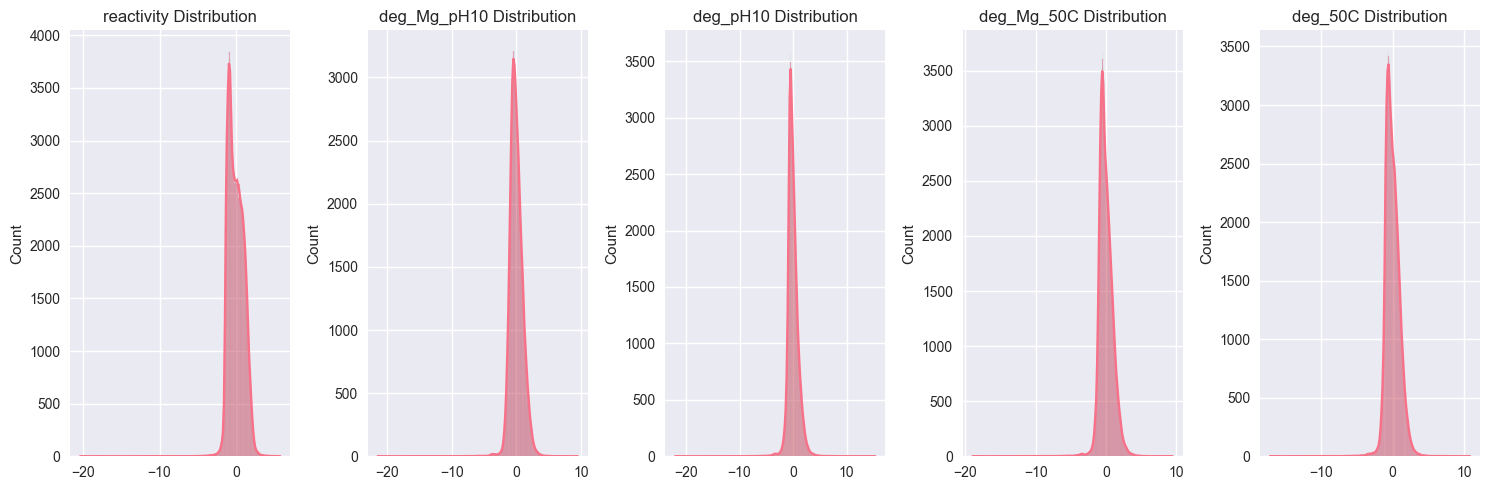


Sequence Length Statistics:
Mean length: 107.0
Std length: 0.0
Min length: 107
Max length: 107


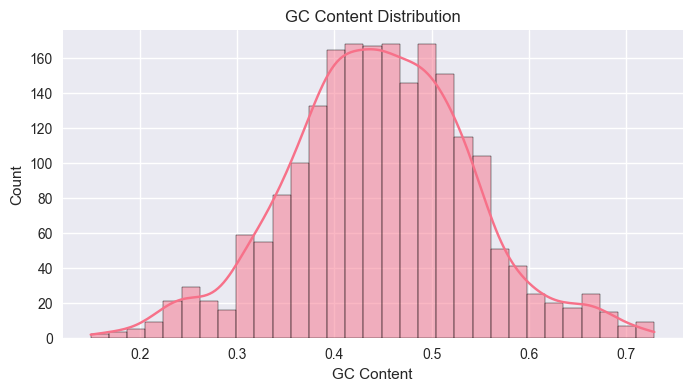


Sample of processed features (first 5 sequences, first 5 features):
          0         1         2         3         4
0  1.447511 -0.249724  1.278871 -1.442000  0.669038
1  0.318839 -0.293333 -1.035402 -2.561211  0.734281
2 -4.051548  2.137637  0.982551  1.747625  0.170657
3 -0.073141 -1.600857  0.705324  1.890385  0.370109
4 -1.828546 -1.462304 -0.514996  1.708097  0.089669

Preprocessing completed successfully!


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from typing import Tuple, Dict, List
import torch

class EnhancedESMPreprocessor:
    def __init__(self, sn_threshold: float = 1.0):
        self.sn_threshold = sn_threshold
        self.robust_scaler = RobustScaler()
        self.power_transformer = PowerTransformer(method='yeo-johnson')
        self.pca = PCA(n_components=0.95)  # Keep 95% of variance
        
    def filter_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter data based on signal-to-noise threshold"""
        return df[df['signal_to_noise'] >= self.sn_threshold].copy()

    def extract_sequence_features(self, sequence: str) -> Dict[str, float]:
        """Extract enhanced sequence features"""
        length = len(sequence)
        dinucleotides = ['AA', 'AU', 'AG', 'AC', 'UA', 'UU', 'UG', 'UC',
                        'GA', 'GU', 'GG', 'GC', 'CA', 'CU', 'CG', 'CC']
        
        features = {
            'gc_content': (sequence.count('G') + sequence.count('C')) / length,
            'au_content': (sequence.count('A') + sequence.count('U')) / length,
            'sequence_length': length,
            'purine_content': (sequence.count('A') + sequence.count('G')) / length,
            'sequence_complexity': len(set(sequence)) / length
        }
        
        # Add dinucleotide frequencies
        for di in dinucleotides:
            count = sum(1 for i in range(length-1) if sequence[i:i+2] == di)
            features[f'dinuc_{di}'] = count / (length - 1)
        
        return features
    
    def extract_structure_features(self, structure: str, sequence: str) -> Dict[str, float]:
        """Extract enhanced structure features"""
        length = len(structure)
        paired_pos = [(i, self.find_pair(structure, i)) for i in range(length) if structure[i] == '(']
        
        features = {
            'paired_ratio': (structure.count('(') + structure.count(')')) / (2 * length),
            'unpaired_ratio': structure.count('.') / length,
            'max_stem_length': self.get_max_stem_length(structure),
            'num_stems': len([1 for i in range(length) if structure[i] == '(' and 
                            (i == 0 or structure[i-1] != '(')]),
            'avg_stem_length': np.mean([self.get_stem_length(structure, i) 
                                      for i in range(length) if structure[i] == '(' and 
                                      (i == 0 or structure[i-1] != '(')] or [0])
        }
        
        # Add base pair features
        if paired_pos:
            gc_pairs = sum(1 for i, j in paired_pos if 
                         (sequence[i] == 'G' and sequence[j] == 'C') or 
                         (sequence[i] == 'C' and sequence[j] == 'G'))
            au_pairs = sum(1 for i, j in paired_pos if 
                         (sequence[i] == 'A' and sequence[j] == 'U') or 
                         (sequence[i] == 'U' and sequence[j] == 'A'))
            
            features['gc_pair_ratio'] = gc_pairs / len(paired_pos)
            features['au_pair_ratio'] = au_pairs / len(paired_pos)
        else:
            features['gc_pair_ratio'] = 0
            features['au_pair_ratio'] = 0
            
        return features
    
    @staticmethod
    def find_pair(structure: str, pos: int) -> int:
        """Find matching pair position in structure"""
        if structure[pos] not in '()':
            return -1
        
        direction = 1 if structure[pos] == '(' else -1
        count = 1
        i = pos + direction
        
        while 0 <= i < len(structure):
            if structure[i] == structure[pos]:
                count += 1
            elif structure[i] == ')' if structure[pos] == '(' else '(':
                count -= 1
                if count == 0:
                    return i
            i += direction
        return -1
    
    @staticmethod
    def get_stem_length(structure: str, start: int) -> int:
        """Get length of stem starting at position"""
        count = 0
        i = start
        while i < len(structure) and structure[i] == '(':
            count += 1
            i += 1
        return count
    
    @staticmethod
    def get_max_stem_length(structure: str) -> int:
        """Get maximum stem length"""
        max_len = 0
        current_len = 0
        for c in structure:
            if c == '(':
                current_len += 1
                max_len = max(max_len, current_len)
            else:
                current_len = 0
        return max_len

    def prepare_esm_input(self, df: pd.DataFrame) -> Tuple[List[str], np.ndarray]:
        """Prepare enhanced features for ESM model"""
        df_filtered = self.filter_data(df)
        
        sequences = []
        feature_dicts = []
        
        for _, row in df_filtered.iterrows():
            seq_features = self.extract_sequence_features(row['sequence'])
            struct_features = self.extract_structure_features(row['structure'], row['sequence'])
            
            combined_features = {
                **seq_features,
                **struct_features,
                'signal_to_noise': row['signal_to_noise']
            }
            
            sequences.append(row['sequence'])
            feature_dicts.append(combined_features)
        
        # Convert to DataFrame and handle missing values
        feature_df = pd.DataFrame(feature_dicts).fillna(0)
        
        # Apply transformations
        scaled_features = self.robust_scaler.fit_transform(feature_df)
        normalized_features = self.power_transformer.fit_transform(scaled_features)
        
        # Reduce dimensionality while preserving important variations
        final_features = self.pca.fit_transform(normalized_features)
        
        return sequences, final_features

    def prepare_targets(self, df: pd.DataFrame) -> Dict[str, torch.Tensor]:
        """Prepare enhanced target variables"""
        df_filtered = self.filter_data(df)
        targets = {}
        
        for prefix in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']:
            target_cols = [col for col in df_filtered.columns 
                         if col.startswith(prefix + '.') and col.split('.')[1].isdigit()]
            
            if target_cols:
                values = df_filtered[target_cols].values.astype(float)
                
                # Apply robust scaling and power transform
                scaled = self.robust_scaler.fit_transform(values)
                normalized = self.power_transformer.fit_transform(scaled)
                
                # Convert to torch tensor
                targets[prefix] = torch.tensor(normalized, dtype=torch.float32)
        
        return targets

def validate_preprocessing(sequences: List[str], features: np.ndarray, targets: Dict[str, torch.Tensor]):
    """Validate preprocessed data"""
    print("\nPreprocessing Validation:")
    print(f"Features shape: {features.shape}")
    print(f"Number of sequences: {len(sequences)}")
    print("\nFeature Statistics:")
    print(pd.DataFrame(features).describe())
    
    print("\nTarget Statistics:")
    for name, target in targets.items():
        print(f"\n{name}:")
        print(f"Shape: {target.shape}")
        print(f"Mean: {target.mean().item():.3f}")
        print(f"Std: {target.std().item():.3f}")

# Main execution code
def main():
    # Initialize preprocessor
    preprocessor = EnhancedESMPreprocessor(sn_threshold=1.0)
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    sequences, features = preprocessor.prepare_esm_input(train_df)
    targets = preprocessor.prepare_targets(train_df)
    
    # Print basic statistics
    print("\nDataset Overview:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Feature matrix shape: {features.shape}")
    print("\nSample sequence:")
    print(sequences[0][:50] + "..." if len(sequences[0]) > 50 else sequences[0])
    
    # Visualize feature distributions
    plt.figure(figsize=(15, 5))
    for i in range(min(5, features.shape[1])):
        plt.subplot(1, 5, i+1)
        sns.histplot(features[:, i], kde=True)
        plt.title(f'Feature {i+1}')
    plt.tight_layout()
    plt.show()
    
    # Print feature correlations
    feature_df = pd.DataFrame(features)
    plt.figure(figsize=(10, 8))
    sns.heatmap(feature_df.corr(), cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.show()
    
    # Analyze targets
    print("\nTarget Statistics:")
    for name, target in targets.items():
        print(f"\n{name}:")
        print(f"Shape: {target.shape}")
        print(f"Mean: {target.mean().item():.3f}")
        print(f"Std: {target.std().item():.3f}")
        print(f"Min: {target.min().item():.3f}")
        print(f"Max: {target.max().item():.3f}")
    
    # Plot target distributions 
    plt.figure(figsize=(15, 5))
    for i, (name, target) in enumerate(targets.items(), 1):
        plt.subplot(1, len(targets), i)
        sns.histplot(target.numpy().flatten(), kde=True)
        plt.title(f'{name} Distribution')
    plt.tight_layout()
    plt.show()
    
    # Analyze sequence characteristics
    sequence_lengths = [len(seq) for seq in sequences]
    print("\nSequence Length Statistics:")
    print(f"Mean length: {np.mean(sequence_lengths):.1f}")
    print(f"Std length: {np.std(sequence_lengths):.1f}")
    print(f"Min length: {min(sequence_lengths)}")
    print(f"Max length: {max(sequence_lengths)}")
    
    # Calculate and print GC content distribution
    gc_contents = [(seq.count('G') + seq.count('C')) / len(seq) for seq in sequences]
    plt.figure(figsize=(8, 4))
    sns.histplot(gc_contents, kde=True)
    plt.title('GC Content Distribution')
    plt.xlabel('GC Content')
    plt.show()
    
    # Print sample of processed features
    print("\nSample of processed features (first 5 sequences, first 5 features):")
    print(pd.DataFrame(features[:5, :5]))
    
    return sequences, features, targets

# Run the analysis
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set up plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette('husl')
    
    try:
        # Run main analysis
        sequences, features, targets = main()
        
        print("\nPreprocessing completed successfully!")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

